In [1]:
%cd ../..

/Users/davideleo/Desktop/Projects/research/papers/fl_wavelet_v0


# Malicious detector 
## Wavelet Analysis

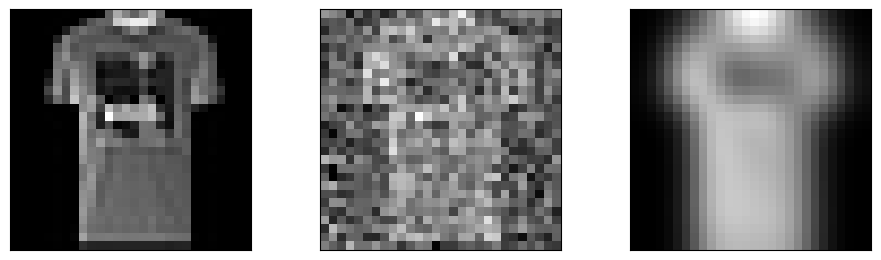

In [2]:
import random 
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from kymatio.torch import Scattering2D
from src.data.newsgroups import get_federation
from src.data.attacks import ShiftEmbedding
from src.domains.detection import train_detector
from sklearn.decomposition import PCA

random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)

# Load a sample image 
dataset = get_federation(num_shards = 1, alpha = 1000)[0]
dataset["test"].load()
x, _ = dataset["test"][0]
dataset["test"].clear()

# Attacks
shift_attack = ShiftEmbedding(proba = .5)
x_shift = shift_attack(x)

torch.Size([1, 17, 3, 3])
torch.Size([1, 17, 3, 3])
torch.Size([1, 17, 3, 3])


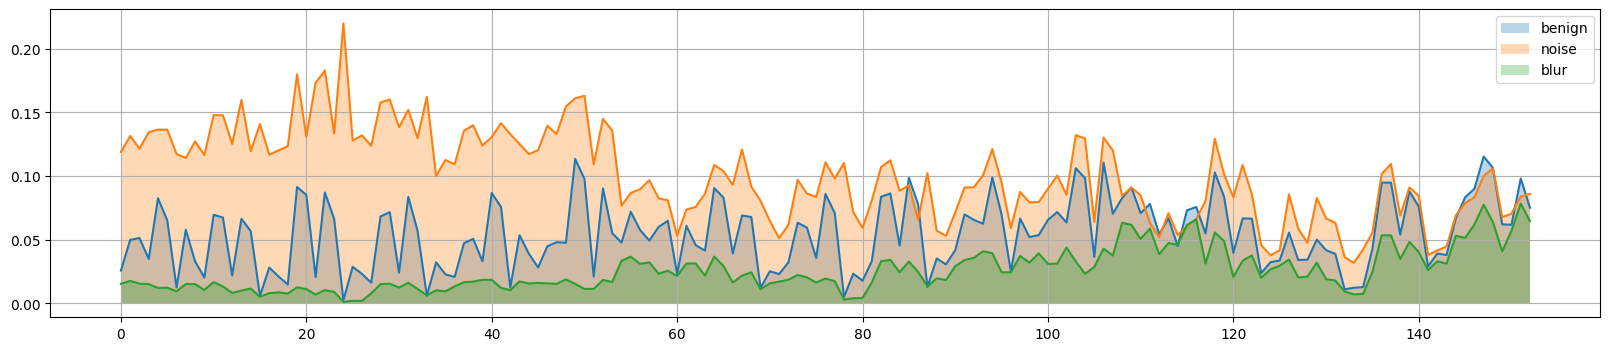

In [4]:
# WST domain extraction 
def wst_domain(
        x: torch.Tensor, 
        J_wst: int = 2,
        L_wst: int = 2
) -> torch.Tensor: 
    # Setup
    _, h, w = x.size()
    wst = Scattering2D(J = J_wst, shape = (h, w), L = L_wst)
    x_wst = wst(x)[:, 1:L_wst * J_wst]
    return x_wst.view(-1)

x_benign_wst = wst_domain(x, J_wst = 3, L_wst = 6)
x_shift_wst = wst_domain(x_shift, J_wst = 3, L_wst = 6)


plt.figure(figsize = (20, 4))
plt.plot(torch.arange(x_benign_wst.size(0)), x_benign_wst)
plt.plot(torch.arange(x_shift_wst.size(0)), x_shift_wst)
plt.fill_between(torch.arange(x_benign_wst.size(0)), 0., x_benign_wst, alpha = .3, label = "benign")
plt.fill_between(torch.arange(x_shift_wst.size(0)), 0., x_shift_wst, alpha = .3, label = "noise")
plt.legend()
plt.grid()
plt.show()

## Clusters visualization 

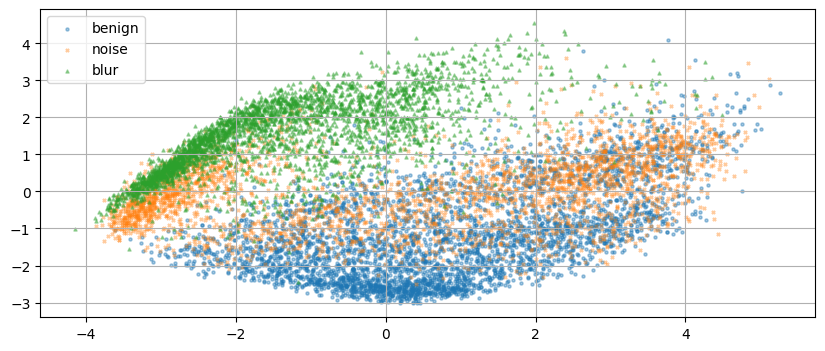

In [14]:
# Dataset 
dataset["test"].load()
X = torch.stack([x for x, _ in dataset["test"].cache])
dataset["test"].clear()

X[4000:7000] = x_shift(X[4000:7000])
X = X[:, 0]

labels = np.zeros(10000, dtype = int)
labels[4000:7000] = 1 
labels[7000:] = 2

# WST domains
J_wst = 2
L_wst = 2
num_samples, height, width = X.size()
wst = Scattering2D(J = J_wst, shape = (height, width), L = L_wst)
X_wst = wst(X).reshape(num_samples, -1)

pca = PCA(n_components = 2, random_state = 42).fit(X_wst)
X_wst_pca = pca.transform(X_wst)

plt.figure(figsize = (10, 4))
plt.scatter(X_wst_pca[labels == 0, 0], X_wst_pca[labels == 0, 1], marker = "o", s = 5, alpha = .4, label = "benign")
plt.scatter(X_wst_pca[labels == 1, 0], X_wst_pca[labels == 1, 1], marker = "x", s = 5, alpha = .4, label = "shift")
plt.grid()
plt.legend()
plt.show()

# Detector training

In [5]:
# Train detector
dataset = get_federation(num_shards = 1, alpha = 1000)[0]

# This is not the model we are going to use for real experiments, 
# this is just a demo
model = train_detector(
    train_dataset = dataset["train"],
    test_dataset = dataset["test"],
    discriminant = "wst",
    discriminant_params = {"J_wst": 2, "L_wst": 4},
    num_epochs = 10, 
    batch_size = 64,
    pca_n_components = None,
    device = "cpu"
)

  0%|          | 0/10 [00:00<?, ?it/s]

- Epoch 1: accuracy_score = 0.4949


 10%|█         | 1/10 [00:20<03:03, 20.34s/it]

- Epoch 2: accuracy_score = 0.5051


 20%|██        | 2/10 [00:32<02:06, 15.76s/it]

- Epoch 3: accuracy_score = 0.5152


 30%|███       | 3/10 [00:45<01:40, 14.36s/it]

- Epoch 4: accuracy_score = 0.8687


 40%|████      | 4/10 [01:01<01:30, 15.07s/it]

- Epoch 5: accuracy_score = 1.0


 50%|█████     | 5/10 [01:39<01:56, 23.24s/it]

- Epoch 6: accuracy_score = 0.9293


 60%|██████    | 6/10 [02:18<01:53, 28.47s/it]

- Epoch 7: accuracy_score = 0.8889


 70%|███████   | 7/10 [02:43<01:22, 27.47s/it]

- Epoch 8: accuracy_score = 0.8283


 80%|████████  | 8/10 [03:08<00:53, 26.81s/it]

- Epoch 9: accuracy_score = 0.8788


100%|██████████| 10/10 [03:32<00:00, 21.29s/it]

- Epoch 10: accuracy_score = 0.9394
